In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import matplotlib.pyplot as plt
# import seaborn as sns
import pmlb as dsets
import numpy as np
import pickle as pkl
from os.path import join as oj
from copy import deepcopy
import pandas as pd
from numpy import array as arr
import time

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy import interpolate
from sklearn.tree import export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree

import torch
from torch import nn

# train an rf

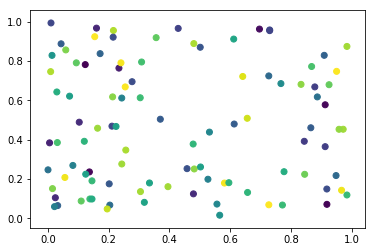

1.0


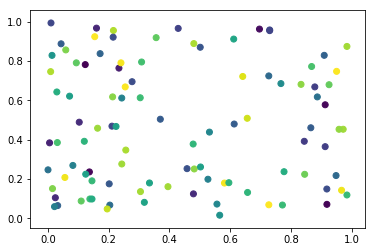

In [2]:
num_features = 4
np.random.seed(13)
N = 100
X = np.random.rand(N, num_features)
# y = np.logical_xor(X[:, 0] > 0.5, X[:, 1] > 0.5)
y = np.random.rand(N)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.show()
rf = DecisionTreeRegressor(max_depth=30)
rf.fit(X, y)
print(rf.score(X, y))
plt.scatter(X[:, 0], X[:, 1], c=rf.predict(X))
plt.show()


# plot_tree(rf.estimators_[0])
# plot_tree(rf)
# plt.show()

# convert to a DNN

In [3]:

def calc_more(n_nodes, children_left, children_right):
    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)


    # calculate node_depth and is_leaves
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
            
    return node_depth, is_leaves



estimator = rf
# The decision estimator has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold
num_leaves = estimator.tree_.n_leaves
num_non_leaves = estimator.tree_.node_count - num_leaves
node_depth, is_leaves = calc_more(n_nodes, children_left, children_right)
values = estimator.tree_.value


'''
recursively store all leaf paths into a dictionary as tuples of (node_idxs, weight)
weight is -1/+1 depending on if it left/right
running_list is a reference to one list which is shared by all calls!
'''
all_leaf_paths = {}
def calc_all_leaf_paths(node_idx, n_nodes, children_left, children_right, running_list):
    
#     print('at', node_idx)
    
    # check if we are at a leaf
    if children_left[node_idx] == children_right[node_idx]:
        all_leaf_paths[node_idx] = deepcopy(running_list)
    else:
        running_list.append((node_idx, -1)) # assign weight of -1 to left
        calc_all_leaf_paths(children_left[node_idx], n_nodes, children_left, children_right, running_list)
        running_list.pop()        
        running_list.append((node_idx, +1)) # assign weight of +1 to right
        calc_all_leaf_paths(children_right[node_idx], n_nodes, children_left, children_right, running_list)
        running_list.pop()
            
calc_all_leaf_paths(0, n_nodes, children_left, children_right, running_list=[])
# all_leaf_paths

In [6]:
class Net(nn.Module):
    def __init__(self, num_features, num_non_leaves, num_leaves):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, num_non_leaves),
            nn.Linear(num_non_leaves, num_leaves), 
            nn.Linear(num_leaves, 1, bias=False)
        )
        
        # 1st and second layers should be initialized to 0
        for i in range(2):
            self.layers[i].weight.data *= 0
            self.layers[i].bias.data *= 0
        
    # assume x shape is (batch_size, ...)
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.layers[0](x) 
#         print('lay 1 weights', self.layers[0].weight)

        x[x < 0] = -1
        x[x >= 0] = 1
#         print('after lay 1', x)
        
        x = self.layers[1](x)
        x = (x == 0).float()
#         print('after lay 2', x)
        
        x = self.layers[2](x)
#         print('after lay 3', x)
        return x
    

net = Net(num_features, num_non_leaves, num_leaves)


# set the first layer
nonleaf_node_to_nonleaf_neuron_num = {} # np.zeros(num_non_leaves)
nonleaf_neuron_num = 0
for i in range(n_nodes):
    if not is_leaves[i]:
#         print(feature[i], threshold[i])
#         nonleaf_indices.append(i)
        net.layers[0].weight.data[nonleaf_neuron_num, feature[i]] = 1
        net.layers[0].bias.data[nonleaf_neuron_num] = -threshold[i]
        nonleaf_node_to_nonleaf_neuron_num[i] = nonleaf_neuron_num
        nonleaf_neuron_num += 1
        
# print(nonleaf_node_to_nonleaf_neuron_num)
# print(net.layers[0].weight.data)



# set the 2nd + 3rd layer
for leaf_neuron_num, leaf_idx in enumerate(sorted(all_leaf_paths.keys())):
    path = all_leaf_paths[leaf_idx]
    for (nonleaf_node, sign) in path:
        net.layers[1].weight.data[leaf_neuron_num, 
                                  nonleaf_node_to_nonleaf_neuron_num[nonleaf_node]] = sign # num_leaves x num_non_leaves
        net.layers[1].bias.data[leaf_neuron_num] = -1 * float(node_depth[leaf_idx])
#         print(input_neuron_num)
    
    # third lay
    net.layers[2].weight.data[0, leaf_neuron_num] = values[leaf_idx][0, 0] # note, this will be multivariate for classification!

    
# test
# x = torch.Tensor(X[:10])    
# pred = net(x)    
    
device = 'cuda'
X_t = torch.Tensor(X)
netg = deepcopy(net).to(device)
X_tg = deepcopy(X_t).to(device)

In [30]:
assert np.isclose(rf.predict(X[:10]).flatten(), net(x).detach().numpy().flatten()).all()

In [60]:
def t(func, num_reps=5):
    ts = []
    for num_rep in range(num_reps):
        s = time.perf_counter()
        func()
        ts.append(time.perf_counter() - s)
    return np.mean(ts)
        

In [75]:
def f1(): rf.predict(X)
def f2(): 
    with torch.no_grad(): 
        net(X_t)
def f3(): 
    with torch.no_grad(): 
        netg(X_tg)

In [78]:
print(f'rf: \t\t{t(f1):0.2e}\n\
dnn cpu: \t{t(f2):0.2e}\n\
dnn gpu: \t{t(f3):0.2e}\n')

rf: 		1.38e-04
dnn cpu: 	5.58e-04
dnn gpu: 	7.08e-04

